<a href="https://colab.research.google.com/github/rezakhanahmadi342341/projects/blob/main/Dental%20OPG%20Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **imports**

In [1]:
import pandas as pd
import numpy as np
import zipfile
import glob
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow import keras
import time
import tensorflow as tf
from tensorflow.keras.applications import VGG16
import kagglehub
kagglehub.login('/content/kaggle.json')
!kaggle datasets download -d imtkaggleteam/dental-opg-xray-dataset/

Dataset URL: https://www.kaggle.com/datasets/imtkaggleteam/dental-opg-xray-dataset/versions/
License(s): Attribution 4.0 International (CC BY 4.0)
 96% 188M/197M [00:01<00:00, 143MB/s]
100% 197M/197M [00:01<00:00, 159MB/s]


# Extract the **dataset**

In [2]:

with zipfile.ZipFile("/content/dental-opg-xray-dataset.zip", 'r') as zip_ref:
   zip_ref.extractall()

# Prepare image paths and labels

In [3]:
image_path = []
label = []
count = []

categories = [
    "BDC-BDR",
    "Caries",
    "Fractured Teeth",
    "Healthy Teeth",
    "Impacted teeth",
    "Infection"
]

for category in categories:
    category_path = f'/content/Dental OPG XRAY Dataset/Dental OPG (Classification)/{category}'
    for imagename in os.listdir(category_path):
        image_path.append(os.path.join(category_path, imagename))
        label.append(category)
        count.append(1)

# Sort image paths and labels
image_path.sort()
label.sort()

# Load and preprocess images

In [4]:
x = []
y = []

for img_path, lbl in zip(image_path, label):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224), 3, interpolation=cv2.INTER_NEAREST)
    x.append(img)
    y.append(lbl)

x = np.array(x)
y = np.array(y)

print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")

Shape of x: (517, 224, 224, 3)
Shape of y: (517,)



# One-hot encode labels

In [5]:
y = np.array(y).reshape(-1, 1)
scale = OneHotEncoder(sparse_output=False)
y = scale.fit_transform(y)

# Split into training and testing sets

In [6]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

# Load pre-trained VGG16 model

In [7]:
base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3))

for layers in base_model.layers:
    layers.trainable = False  # Freeze the layers

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


# Define the model

In [8]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(6, activation='softmax')  # Assuming 6 classes
])

# Compile the model

In [9]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1000)                │     138,357,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138,486,958 (528.29 MB)

 Trainable params: 129,158 (504.52 KB)

 Non-trainable params: 138,357,800 (527.79 MB)


# Train the model

In [10]:
hist = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3086 - loss: 1.7788 - val_accuracy: 0.4231 - val_loss: 1.7332
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.4148 - loss: 1.7015 - val_accuracy: 0.4231 - val_loss: 1.6703
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.3892 - loss: 1.6330 - val_accuracy: 0.4231 - val_loss: 1.6062
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.4245 - loss: 1.5468 - val_accuracy: 0.4231 - val_loss: 1.5537
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.3844 - loss: 1.5397 - val_accuracy: 0.4231 - val_loss: 1.5279
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.4287 - loss: 1.4459 - val_accuracy: 0.4231 - val_loss: 1.5187
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.4189 - loss: 1.4648 - val_accuracy: 0.4231 - val_loss: 1.5193
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - accuracy: 0.4424 - loss: 1.4096 - val_accuracy: 0.42

# Plot accuracy and loss

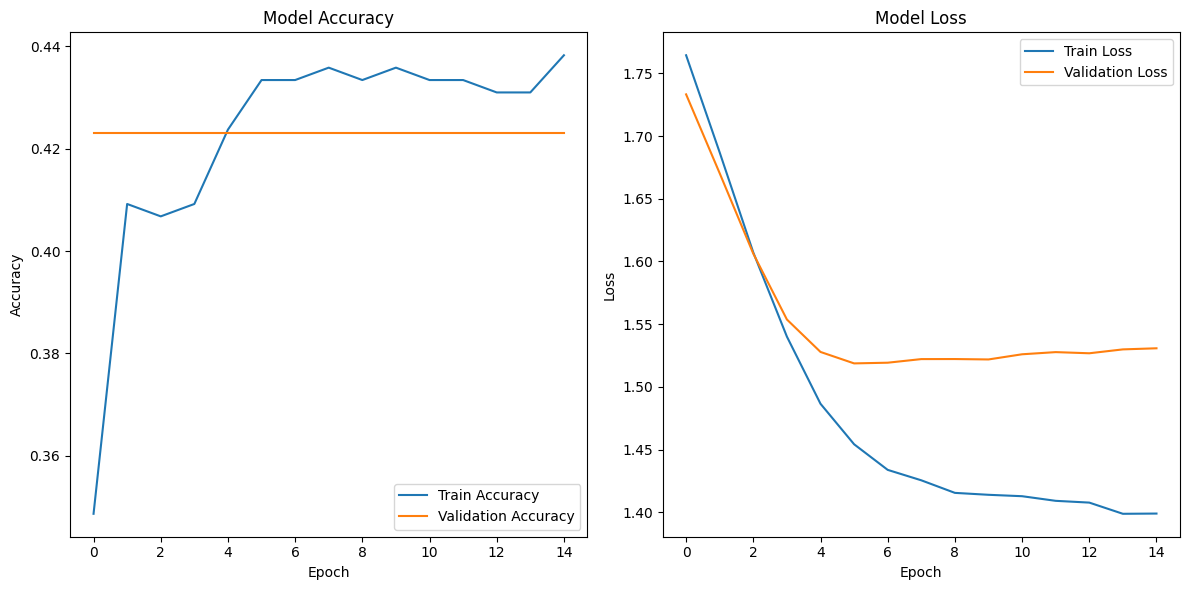

In [11]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#Final score

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pre  = model.predict(x_test)
accuracy = accuracy_score(y_test.argmax(axis=1), pre.argmax(axis=1))
print(f"Accuracy: {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step
Accuracy: 0.4230769230769231
